In [33]:
import numpy as np
import matplotlib.pyplot as plt
from corner import corner
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp

tfk = tf.keras
tfd = tfp.distributions
tfb = tfp.bijectors

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
def powerlaw(x, slope, lo, hi):
    
    return (
        (x >= lo) * (x <= hi)
        * x**slope
        * (slope+1) / (hi**(slope+1) - lo**(slope+1))
        )

def sample_powerlaw(n_samples, slope, lo, hi):
    
    x = np.random.uniform(size=n_samples)
    
    return (lo**(slope+1) + x * (hi**(slope+1) - lo**(slope+1)))**(1/(slope+1))

In [3]:
n_slopes = 10
n_dim = 2
n_samples = 10000
lo = 0
hi = 1

slopes = np.linspace(0, 5, n_slopes)
data = sample_powerlaw([n_slopes, n_samples, n_dim], slopes[:, None, None], lo, hi)

slopes.shape, data.shape

((10,), (10, 10000, 2))

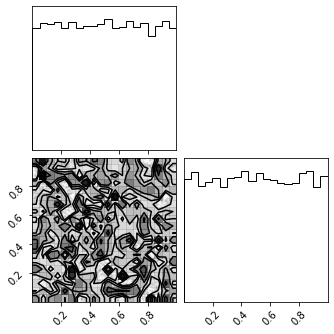

In [4]:
i = 0
corner(data[i]);

In [5]:
slopes = np.repeat(slopes[:, None, None], n_samples, axis=1)
slopes.shape

(10, 10000, 1)

In [6]:
slopes = slopes.reshape(-1, 1)
data = data.reshape(-1, n_dim)
slopes.shape, data.shape

((100000, 1), (100000, 2))

In [7]:
class Norm:
    
    def __init__(self, data):
        
        self.mean = np.mean(data, axis=0)
        self.std = np.std(data, axis=0)
        
    def forward(self, x):
        
        return (x - self.mean) / self.std
    
    def inverse(self, y):
        
        return y * self.std + self.mean

In [8]:
slopes_norm = Norm(slopes)
slopes = slopes_norm.forward(slopes)
data_norm = Norm(data)
data = data_norm.forward(data)

array([-1.5666989])

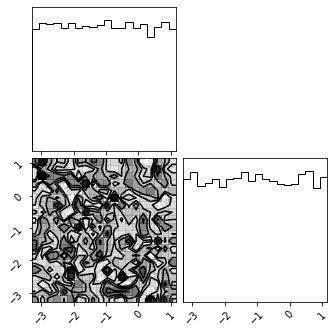

In [9]:
i = 0
corner(data[n_samples*i:n_samples*(i+1)]);
np.unique(slopes[n_samples*i:n_samples*(i+1)])

In [10]:
# https://github.com/tensorflow/probability/issues/1410
# https://github.com/tensorflow/probability/issues/1006#issuecomment-663141106

import re

def make_bijector_kwargs(bijector, name_to_kwargs):
    if hasattr(bijector, 'bijectors'):
        return {b.name: make_bijector_kwargs(b, name_to_kwargs) for b in bijector.bijectors}
    else:
        for name_regex, kwargs in name_to_kwargs.items():
            if re.match(name_regex, bijector.name):
                return kwargs
    return {}

def make_kwargs(flow, condition):
    
    name_to_kwargs = {'maf.': {'conditional_input': condition}}
    
    return make_bijector_kwargs(flow.bijector, name_to_kwargs)

# def make_kwargs(flow, condition):
    
#     prefix = flow.bijector.bijectors[-1].name[:-1]
    
#     return {
#         b.name: {'conditional_input': condition}
#         for b in flow.bijector.bijectors if prefix in b.name
#         }

In [126]:
n_flows = 10
n_layers = 1
n_units = 1024

activation = 'relu'

bijectors = []

shift = -float(abs(data_norm.forward(lo)[0]))
scale = float(data_norm.forward(hi)[0] - data_norm.forward(lo)[0])
bijectors.append(tfb.Shift(shift=shift))
bijectors.append(tfb.Scale(scale=scale))
bijectors.append(tfb.Scale(scale=.5))
bijectors.append(tfb.Shift(shift=1.))
bijectors.append(tfb.Tanh())

for i in range(n_flows):
    
    made = tfb.AutoregressiveNetwork(
        params=2,
        event_shape=(n_dim,),
        conditional=True,
        conditional_event_shape=(1,),
        #conditional_input_layers='all_layers',
        hidden_units=[n_units]*n_layers,
        #input_order='left-to-right',
        #hidden_degrees='equal',
        activation='relu',
        #use_bias=True,
        kernel_initializer=tfk.initializers.RandomNormal(mean=0., stddev=.01),
        bias_initializer='zeros', #tfk.initializers.RandomNormal(mean=0., stddev=.01),
        # kernel_regularizer=tf.keras.regularizers.L2(l2=1e-3),
        # bias_regularizer=tf.keras.regularizers.L2(l2=1e-3),
        #kernel_constraint=None,
        #bias_constraint=None,
        #validate_args=False,
        name=f'made{i}'
        )
    maf = tfb.MaskedAutoregressiveFlow(made, name=f'maf{i}')
    bijectors.append(maf)
    
    if i < n_flows-1:
    
        # batchnorm = tfb.BatchNormalization(training=True, name=f'batchnorm{i}')
        # bijectors.append(tfb.Invert(batchnorm))

        permute = tfb.Permute(list(reversed(range(n_dim))), name=f'permute{i}')
        bijectors.append(permute)
    
bijector = tfb.Chain(bijectors)
distribution = tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=[n_dim])
nf = tfd.TransformedDistribution(distribution=distribution, bijector=bijector)

x = tf.keras.Input(shape=(n_dim,), dtype=tf.float32)
c = tf.keras.Input(shape=(1,), dtype=tf.float32)

log_prob = nf.log_prob(
    x,
    bijector_kwargs=make_kwargs(nf, c),
    # bijector_kwargs=make_bijector_kwargs(
    #     nf.bijector, {'maf.': {'conditional_input': c}},
    #     ),
    )

model = tf.keras.Model([x, c], log_prob)

In [127]:
epochs = 10
batch_size = 100
learning_rate = 1e-4

model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
    loss=lambda _, log_prob: -log_prob,
    )

result = model.fit(
    x=[data, slopes],
    y=np.zeros(n_samples*n_slopes, dtype=np.float32),
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    verbose=1,
    )

Epoch 1/10
1000/1000 [==============================] - 24s 21ms/step - loss: 2.0591
Epoch 2/10
1000/1000 [==============================] - 20s 20ms/step - loss: 1.9779
Epoch 3/10
1000/1000 [==============================] - 20s 20ms/step - loss: 1.9748
Epoch 4/10
1000/1000 [==============================] - 20s 20ms/step - loss: 1.9731
Epoch 5/10
1000/1000 [==============================] - 20s 20ms/step - loss: 1.9730
Epoch 6/10
1000/1000 [==============================] - 20s 20ms/step - loss: 1.9726
Epoch 7/10
1000/1000 [==============================] - 20s 20ms/step - loss: 1.9723
Epoch 8/10
1000/1000 [==============================] - 20s 20ms/step - loss: 1.9720
Epoch 9/10
1000/1000 [==============================] - 20s 20ms/step - loss: 1.9717
Epoch 10/10
1000/1000 [==============================] - 20s 20ms/step - loss: 1.9713


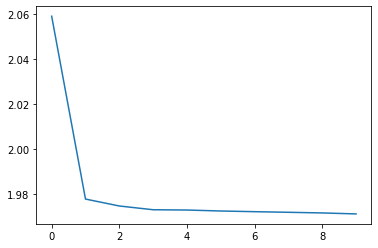

In [130]:
plt.plot(result.history['loss'][0:]);

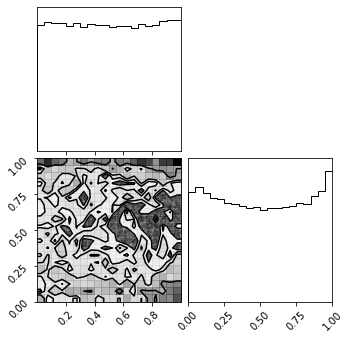

In [132]:
slope = 0
n = 100000

#condition = slope * np.ones((n, 1))
condition = slopes_norm.forward(slope) * np.ones((n, 1))
bijector_kwargs = make_kwargs(nf, condition)

samples = nf.sample(n, bijector_kwargs=bijector_kwargs).numpy()
#samples = distribution.sample(n_samples)
#samples = nf.bijector.forward(samples, **bijector_kwargs).numpy()
samples = data_norm.inverse(samples)

corner(samples);

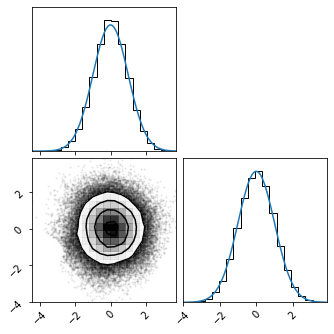

In [134]:
slope = 0.
n = 100000

condition = slopes_norm.forward(slope) * np.ones((n, 1))
#condition = slope * np.ones((n, 1))
bijector_kwargs = make_kwargs(nf, condition)

samples = sample_powerlaw([n, n_dim], slope, lo, hi)
samples = data_norm.forward(samples)
samples = nf.bijector.inverse(samples, **bijector_kwargs).numpy()

fig = corner(samples, hist_kwargs=dict(density=True))

axs = np.reshape(fig.axes, (n_dim, n_dim))
for i in range(n_dim):
    x = np.linspace(-5, 5, 100)
    y = np.exp(-x**2/2) / (2*np.pi)**.5
    axs[i, i].plot(x, y)